Setup complete.
Data prepared. Shape: (45834, 2383), Classes: 14
Class weights computed for imbalance correction.

Training MLP ...
Epoch 1/80
645/645 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.1039 - loss: 5.2919 - val_accuracy: 0.0982 - val_loss: 3.0804 - learning_rate: 0.0010
Epoch 2/80
645/645 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.0620 - loss: 6.1776 - val_accuracy: 0.0345 - val_loss: 2.9434 - learning_rate: 0.0010
Epoch 3/80
645/645 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.0715 - loss: 4.0081 - val_accuracy: 0.0308 - val_loss: 3.0207 - learning_rate: 0.0010
Epoch 4/80
645/645 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.0514 - loss: 4.4426 - val_accuracy: 0.0225 - val_loss: 2.7777 - learning_rate: 0.0010
Epoch 5/80
645/645 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.0645 - loss: 3.3817 - val_accuracy: 0.0364 - val_loss: 2.5743 - learning_rate: 0.0010
Epoch 6/80
645/645 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.0633 - loss: 4.0582 - val_accu

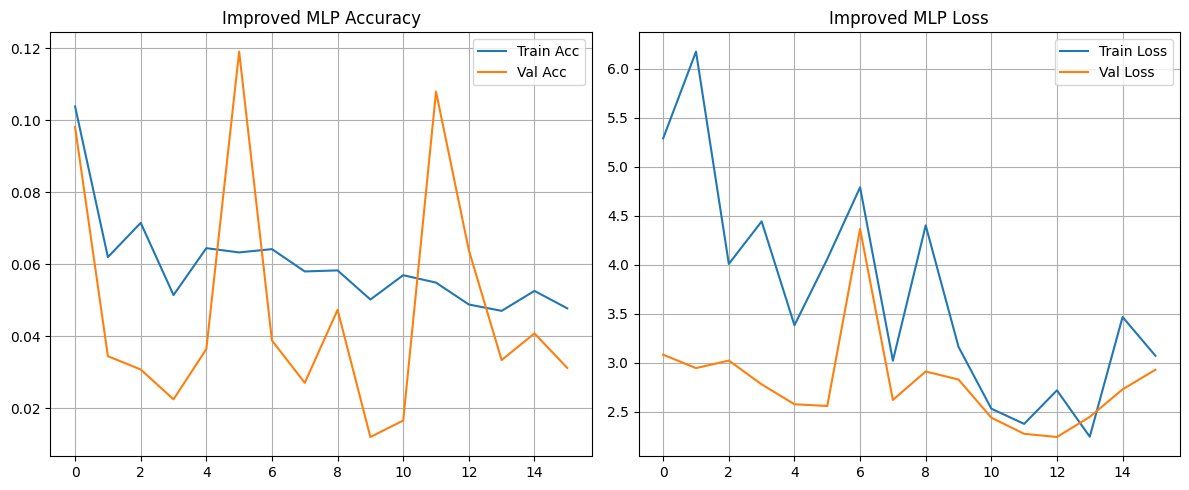

359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

MLP Classification Report:
                    precision    recall  f1-score   support

          backdoor       0.15      0.05      0.07      1466
       cryptominer       0.00      0.25      0.00         4
        downloader       0.01      0.08      0.02       206
           dropper       0.02      0.10      0.03       143
           exploit       0.00      0.00      0.00         2
informationstealer       0.01      0.03      0.02        90
          p2p-worm       0.00      0.00      0.00         3
               pua       0.00      0.17      0.00         6
        ransomware       0.01      0.01      0.01       164
           rootkit       0.00      0.00      0.00         1
            trojan       0.53      0.20      0.29      5995
  trojan-gamethief       0.00      0.00      0.00         1
             virus       0.00      0.00      0.00        38
              worm       0.39      0.04      0.07      3340

          accuracy           

KeyboardInterrupt: 

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, BatchNormalization,
    Conv1D, GlobalAveragePooling1D, ReLU, Add
)
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# CONFIG
FEATURES_DIR = Path("features")
MODELS_DIR = Path("models/deep_learning_improved")
MODELS_DIR.mkdir(parents=True, exist_ok=True)
EPOCHS = 80
BATCH_SIZE = 64
print("Setup complete.")

def plot_learning_curves(history, model_name):
    hist = pd.DataFrame(history.history)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(hist["accuracy"], label="Train Acc")
    plt.plot(hist["val_accuracy"], label="Val Acc")
    plt.title(f"{model_name} Accuracy")
    plt.legend(); plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(hist["loss"], label="Train Loss")
    plt.plot(hist["val_loss"], label="Val Loss")
    plt.title(f"{model_name} Loss")
    plt.legend(); plt.grid(True)
    plt.tight_layout()
    plt.show()

X = pd.read_pickle(FEATURES_DIR / "X_features.pkl")
y_raw = pd.read_pickle(FEATURES_DIR / "y_labels.pkl")

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)
num_classes = len(label_encoder.classes_)
y_cat = to_categorical(y, num_classes=num_classes)

X_train, X_test, y_train, y_test = train_test_split(
    X.values, y_cat, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(f"Data prepared. Shape: {X_train.shape}, Classes: {num_classes}")

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y),
    y=y
)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights computed for imbalance correction.")

def build_mlp(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Dense(1024, activation="relu")(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=AdamW(learning_rate=1e-3),
                  loss="categorical_crossentropy", metrics=["accuracy"])
    return model

def resnet_block(x, filters, kernel_size=3):
    fx = Conv1D(filters, kernel_size, padding="same")(x)
    fx = BatchNormalization()(fx)
    fx = ReLU()(fx)
    fx = Conv1D(filters, kernel_size, padding="same")(fx)
    fx = BatchNormalization()(fx)
    if x.shape[-1] != filters:
        x = Conv1D(filters, 1, padding="same")(x)
    out = Add()([x, fx])
    out = ReLU()(out)
    return out

def build_resnet1d(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, 5, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    for _ in range(3):
        x = resnet_block(x, 64)
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=AdamW(learning_rate=1e-3),
                  loss="categorical_crossentropy", metrics=["accuracy"])
    return model

#CALLBACKS
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor="val_accuracy"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1)
]

#TRAIN MLP 
print("\nTraining MLP ...")
mlp_model = build_mlp((X_train.shape[1],), num_classes)
mlp_history = mlp_model.fit(
    X_train, y_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    validation_split=0.1, verbose=1,
    class_weight=class_weights_dict,
    callbacks=callbacks
)
plot_learning_curves(mlp_history, "Improved MLP")

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(mlp_model.predict(X_test), axis=1)
print("\nMLP Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_, zero_division=0))
mlp_model.save(MODELS_DIR / "mlp_improved.keras")
print("MLP saved.\n")

#TRAIN RESNET1D 
print("\nTraining ResNet1D ...")
X_train_res = np.expand_dims(X_train, axis=-1)
X_test_res = np.expand_dims(X_test, axis=-1)
resnet_model = build_resnet1d(X_train_res.shape[1:], num_classes)
resnet_history = resnet_model.fit(
    X_train_res, y_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    validation_split=0.1, verbose=1,
    class_weight=class_weights_dict,
    callbacks=callbacks
)
plot_learning_curves(resnet_history, "Improved ResNet1D")

y_pred_res = np.argmax(resnet_model.predict(X_test_res), axis=1)
print("\nResNet1D Classification Report:")
print(classification_report(y_true, y_pred_res, target_names=label_encoder.classes_, zero_division=0))
resnet_model.save(MODELS_DIR / "resnet1d_improved.keras")
print("ResNet1D saved successfully.")
